In [1]:
import torch
from neuromancer.psl import plot
from neuromancer import psl
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from neuromancer.system import Node
from neuromancer.dynamics import integrators, ode
from neuromancer.trainer import Trainer
from neuromancer.problem import Problem
from neuromancer.loggers import BasicLogger
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.modules import blocks

torch.manual_seed(0)


In [25]:
import pandas as pd 
df = pd.read_csv('HistoricalData_SPX.csv')
df.head()

,Date,Close/Last,Open,High,Low
0,02/29/2024,5096.27,5085.36,5104.99,5061.89
1,02/28/2024,5069.76,5067.20,5077.37,5058.35
2,02/27/2024,5078.18,5074.60,5080.69,5057.29
3,02/26/2024,5069.53,5093.00,5097.66,5068.91
4,02/23/2024,5088.80,5100.92,5111.06,5081.46


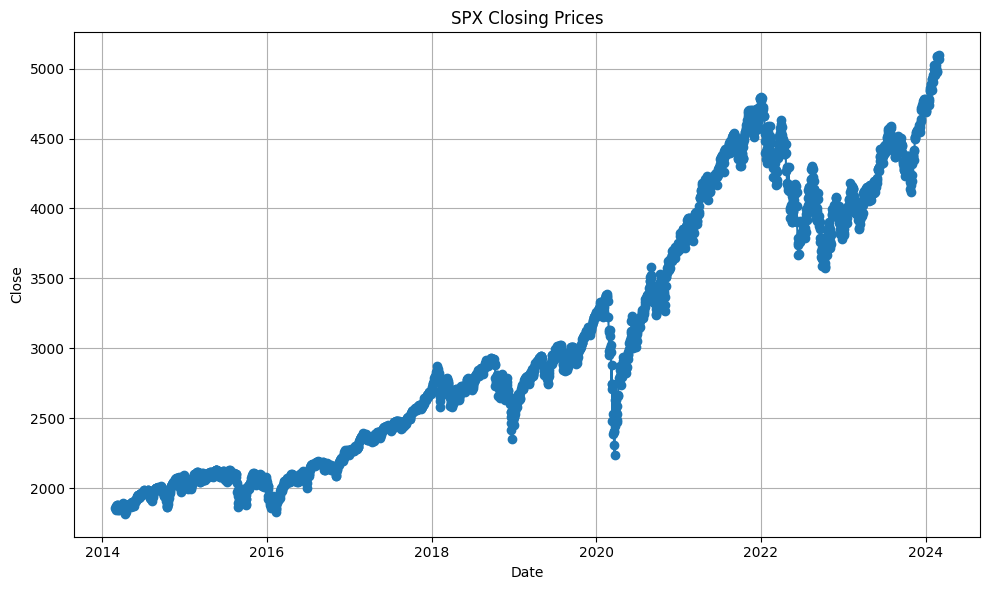

In [26]:
import matplotlib.pyplot as plt

# Assuming df is your DataFrame containing the stock data
# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Plot Close/Last price over time
plt.figure(figsize=(10, 6))
plt.plot(df['Date'][::-1], df['Close/Last'][::-1], marker='o', linestyle='-')
plt.title('SPX Closing Prices')
plt.xlabel('Date')
plt.ylabel('Close')
plt.grid(True)
plt.tight_layout()
plt.show()

In [28]:
from sklearn.preprocessing import MinMaxScaler

# Assuming your DataFrame is named df
# Selecting only the numerical columns to standardize
numerical_columns = ['Close/Last']

# Instantiate the StandardScaler
scaler = MinMaxScaler()

# Fit and transform the numerical columns
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

In [29]:
df

,Date,Close/Last,Open,High,Low
0,2024-02-29,1.000000,5085.36,5104.99,5061.89
1,2024-02-28,0.991919,5067.20,5077.37,5058.35
2,2024-02-27,0.994486,5074.60,5080.69,5057.29
3,2024-02-26,0.991849,5093.00,5097.66,5068.91
4,2024-02-23,0.997723,5100.92,5111.06,5081.46
...,...,...,...,...,...
2528,2014-03-06,0.018698,1874.18,1881.94,1874.18
2529,2014-03-05,0.017716,1874.05,1876.53,1871.11
2530,2014-03-04,0.017747,1849.23,1876.23,1849.23
2531,2014-03-03,0.009157,1857.68,1857.68,1834.44


In [30]:
df = df.reset_index()
ts = (df['index'].values)[::-1]
ts = ts[::-1]
ts = torch.tensor(ts, dtype=torch.float32)
xs = (df['Close/Last'].values)
xs = torch.tensor(xs, dtype=torch.float32).flip(0)

#xs needs to be of shape [t, batch_size, data_dimensions=1]
xs = xs.unsqueeze(1).unsqueeze(2)





In [127]:
ts = 0.


2533

In [31]:
device='cpu'
batch_size = 1
train_data = DictDataset({'xs':xs},name='train')
train_data_loader = DataLoader(train_data, batch_size=2533, collate_fn=train_data.collate_fn, shuffle=False)

In [154]:
xs.shape

torch.Size([2533, 1, 3])

In [32]:
input_dim = 1

latent_size=2
context_size=4
hidden_size=4
lr_init=1e-2
t0=0.
t1=2532.
lr_gamma=0.997
num_iters=1
kl_anneal_iters=1000
pause_every=50
noise_std=0.01
adjoint=False
train_dir='./dump/stock_forecasting/'
method="euler"

sde_block_encoder = blocks.LatentSDE_Encoder(input_dim, latent_size, context_size, hidden_size, ts=ts) 
integrator = integrators.LatentSDEIntegrator(sde_block_encoder, dt=1.)
model_1 = Node(integrator, input_keys=['xs'], output_keys=['zs', 'z0', 'log_ratio',  'xs', 'qz0_mean', 'qz0_logstd'], name='m1')
sde_block_decoder = blocks.LatentSDE_Decoder(input_dim, latent_size, noise_std=noise_std)
model_2 = Node(sde_block_decoder, input_keys=['xs', 'zs', 'log_ratio', 'qz0_mean', 'qz0_logstd'], output_keys=['log_pxs', 'sum_term', 'log_ratio'], name='m2' )

xs = variable('xs')
zs = variable('zs')
z0 = variable('z0')


log_ratio = variable('log_ratio')
qz0_mean = variable('qz0_mean')
qz0_logstd = variable('qz0_logstd')
log_pxs = variable('log_pxs')
sum_term = variable('sum_term')



loss = (-1.0*log_pxs + log_ratio) == 0.0


# aggregate list of objective terms and constraints
objectives = [loss]
constraints = []
# create constrained optimization loss
loss = PenaltyLoss(objectives, constraints)
# construct constrained optimization problem
problem = Problem([model_1, model_2], loss)

In [34]:

baz = next(iter(train_data_loader))
baz['xs'].shape
foo = model_1(baz)
foo

{'zs': tensor([[[-1.0134e+00,  4.9340e-01]],
 
         [[-1.3344e+00, -1.6515e-01]],
 
         [[-1.9389e+00, -9.6584e-01]],
 
         ...,
 
         [[ 2.3176e+07, -6.6517e+06]],
 
         [[ 2.3289e+07, -6.6841e+06]],
 
         [[ 2.3402e+07, -6.7167e+06]]], grad_fn=<SplitWithSizesBackward0>),
 'z0': tensor([[-1.0134,  0.4934]], grad_fn=<AddBackward0>),
 'log_ratio': tensor([[2.0297],
         [1.8233],
         [1.5270],
         ...,
         [   nan],
         [   nan],
         [   nan]], grad_fn=<SqueezeBackward1>),
 'xs': tensor([[[0.0133]],
 
         [[0.0092]],
 
         [[0.0177]],
 
         ...,
 
         [[0.9945]],
 
         [[0.9919]],
 
         [[1.0000]]]),
 'qz0_mean': tensor([[-0.0452,  0.4826]], grad_fn=<SplitBackward0>),
 'qz0_logstd': tensor([[-0.3319, -0.4354]], grad_fn=<SplitBackward0>)}

{'zs': tensor([[[0.9840, 0.7725]],
 
         [[2.7798, 1.1453]],
 
         [[4.1100, 1.9832]],
 
         ...,
 
         [[   nan,    nan]],
 
         [[   nan,    nan]],
 
         [[   nan,    nan]]], grad_fn=<SplitWithSizesBackward0>),
 'z0': tensor([[0.9840, 0.7725]], grad_fn=<AddBackward0>),
 'log_ratio': tensor([[3.6686],
         [5.0823],
         [6.7811],
         ...,
         [   nan],
         [   nan],
         [   nan]], grad_fn=<SqueezeBackward1>),
 'xs': tensor([[[-1.2923]],
 
         [[-1.3073]],
 
         [[-1.2766]],
 
         ...,
 
         [[ 2.2042]],
 
         [[ 2.1950]],
 
         [[ 2.2238]]]),
 'qz0_mean': tensor([[0.0863, 0.4421]], grad_fn=<SplitBackward0>),
 'qz0_logstd': tensor([[-0.4505, -0.4765]], grad_fn=<SplitBackward0>)}

In [36]:
optimizer = torch.optim.Adam(problem.parameters(), lr=0.001)


# define neuromancer trainer
trainer = Trainer(
    problem,
    train_data_loader,
    train_data_loader,
    train_data_loader,
    optimizer,
    patience=0,
    clip=100,
    warmup=0,
    epochs=15,
    eval_metric="train_loss",
    train_metric="train_loss",
    dev_metric="train_loss",
    test_metric="train_loss"
)
trainer.train()

ValueError: Expected parameter loc (Tensor of shape (2533, 1, 1)) of distribution Normal(loc: torch.Size([2533, 1, 1]), scale: torch.Size([2533, 1, 1])) to satisfy the constraint Real(), but found invalid values:
tensor([[[nan]],

        [[nan]],

        [[nan]],

        ...,

        [[nan]],

        [[nan]],

        [[nan]]], grad_fn=<AddBackward0>)